In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from os import listdir


In [2]:
data_path = './fd-1kpc-9.6sm-0-overlaid.csv/npy0/'
file_list = listdir(data_path)

In [3]:
siglist=[]
for items in file_list:
    data = np.load( os.path.join( data_path, items ) )
    siglist.append(data['sig'])

sigindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==1]
bkgindex=np.array(file_list, dtype='U')[np.array(siglist, dtype=int)==0]
print(len(sigindex))
print(len(bkgindex))

1748
252


In [3]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
class MyDataset(Dataset):
    def __init__(self, data_path_, file_list_):
        self.data_path = data_path_
        self.file_list = file_list_
        self.len = len(file_list_)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        data = np.load( os.path.join( self.data_path, file_name ) )
        return torch.from_numpy(data['imxz'][None, :, :]).to(torch.float)/4096, torch.from_numpy(data['imyz'][None, :, :]).to(torch.float)/4096, torch.from_numpy(data['sig']).to(torch.long)
    def __len__(self):
        return self.len

mydataset = MyDataset(data_path, file_list)
batch_size_train = 6
batch_size_test = 4


train_size = int(0.8 * len(mydataset))
test_size = len(mydataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(mydataset, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
                                            shuffle=False)                

In [4]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1_1 = nn.Conv2d(1, 64, 5) 
        self.conv1_2 = nn.Conv2d(1, 64, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2_1 = nn.Conv2d(64, 16, 5)
        self.conv2_2 = nn.Conv2d(64, 16, 5)
        self.fc1_1 = nn.Linear(16 * 221 * 93, 10)
        self.fc1_2 = nn.Linear(16 * 221 * 93, 10)
        self.fc2= nn.Linear(20, 2)

    def forward(self, x1, x2):
        # x1, x2 shape: (896, 384)      channel = 1
        x1 = self.pool(F.relu(self.conv1_1(x1))) # shape: (896, 384)->(892, 380)->(446, 190)
        x1 = self.pool(F.relu(self.conv2_1(x1))) # shape: (446, 190)->(442, 186)->(221, 93)
        x1 = torch.flatten(x1, 1) # flatten all dimensions except batch 
        x1 = F.relu(self.fc1_1(x1))

        x2 = self.pool(F.relu(self.conv1_2(x2))) # shape: (896, 384)->(892, 380)->(446, 190)
        x2 = self.pool(F.relu(self.conv2_2(x2))) # shape: (446, 190)->(442, 186)->(221, 93)
        x2 = torch.flatten(x2, 1) # flatten all dimensions except batch 
        x2 = F.relu(self.fc1_2(x2))

        return self.fc2(torch.cat((x1, x2), 1))
net=Net().cuda()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss(weight=torch.tensor([1., 1.]).cuda())
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [6]:
sum(p.numel() for p in net.parameters())

6631582

In [7]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1660 Ti'

In [11]:
# Training
loss_list = []
alpha=0.2
epochs = 100


accuracy_list = []

for i in range(epochs):
    net.train()
    for (batch_idx, batch) in enumerate(trainloader):
        XZ_train_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_train_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        sig_train_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

        Netout = net.forward(XZ_train_batch, YZ_train_batch) # This will call the forward function, usually it returns tensors.
        #print(F.softmax(Netout))
        loss = criterion(Netout, sig_train_batch) # classification loss

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad() 
        
        # Backward pass: compute gradient of the loss with respect to all the learnable
        # parameters of the model. Internally, the parameters of each Module are stored
        # in Tensors with requires_grad=True, so this call will compute gradients for
        # all learnable parameters in the model.
        loss.backward()
        
        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()

        loss_list.append(loss)
        if batch_idx % 50 == 0 or True:
            #print("Epoch: {}, batch: {} Loss: {} label_loss:{}".format(i, batch_idx, loss, label_loss_))
            print("Epoch: {}, batch: {} Loss: {:0.4f}".format(i, batch_idx, loss))
    
    net.eval() # begin testing
    preds = np.array([])
    reals = np.array([])

    with torch.no_grad():
        for (batch_idx, batch) in enumerate(testloader):
            XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
            YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
            sig_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

            Netout = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.
            #print(Netout.shape)
            prediction=F.softmax(Netout, dim=1).argmax(dim=1)
            

            preds=np.concatenate((preds, prediction.cpu().detach().numpy().flatten()))
            reals=np.concatenate((reals, sig_test_batch.cpu().detach().numpy().flatten()))
        preds=np.array(preds)
        reals=np.array(reals)
        accuracy=np.mean(preds==reals)
        accuracy_list.append(accuracy)
        print("Test accuracy: {}".format(accuracy))


Epoch: 0, batch: 0 Loss: 0.4806
Epoch: 0, batch: 1 Loss: 0.2642
Epoch: 0, batch: 2 Loss: 0.6992
Epoch: 0, batch: 3 Loss: 0.1672
Epoch: 0, batch: 4 Loss: 0.4598
Epoch: 0, batch: 5 Loss: 0.0983
Epoch: 0, batch: 6 Loss: 0.5067
Epoch: 0, batch: 7 Loss: 0.0568
Epoch: 0, batch: 8 Loss: 0.5624
Epoch: 0, batch: 9 Loss: 0.0392
Epoch: 0, batch: 10 Loss: 0.5945
Epoch: 0, batch: 11 Loss: 0.5863
Epoch: 0, batch: 12 Loss: 0.5617
Epoch: 0, batch: 13 Loss: 0.5281
Epoch: 0, batch: 14 Loss: 0.4916
Epoch: 0, batch: 15 Loss: 0.8164
Epoch: 0, batch: 16 Loss: 0.4501
Epoch: 0, batch: 17 Loss: 0.4539
Epoch: 0, batch: 18 Loss: 0.2728
Epoch: 0, batch: 19 Loss: 0.3047
Epoch: 0, batch: 20 Loss: 0.8092
Epoch: 0, batch: 21 Loss: 0.3421
Epoch: 0, batch: 22 Loss: 0.3501
Epoch: 0, batch: 23 Loss: 0.4920
Epoch: 0, batch: 24 Loss: 0.4872
Epoch: 0, batch: 25 Loss: 0.3148
Epoch: 0, batch: 26 Loss: 0.4703
Epoch: 0, batch: 27 Loss: 0.2566
Epoch: 0, batch: 28 Loss: 0.2169
Epoch: 0, batch: 29 Loss: 0.4510
Epoch: 0, batch: 30 

KeyboardInterrupt: 

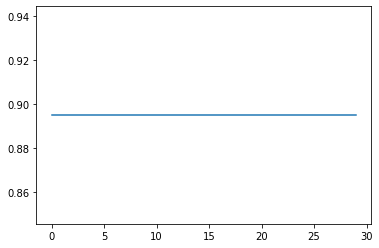

In [14]:
plt.plot(range(len(accuracy_list)), accuracy_list) 

In [17]:
siglist=[]
for items in file_list:
    data = np.load( os.path.join( data_path, items ) )
    siglist.append([items, data['sig']])

In [ ]:
siglist

In [9]:
with torch.no_grad():
    # Prediction
    preds = []
    reals = []

    for (batch_idx, batch) in enumerate(testloader):
        XZ_test_batch = batch[0].cuda() # remove .cuda() if you don't have a GPU
        YZ_test_batch = batch[1].cuda() # remove .cuda() if you don't have a GPU
        sig_test_batch = batch[2].cuda() # remove .cuda() if you don't have a GPU

        #print(XZ_test_batch[0], '\n\n', YZ_test_batch[0])

        Netout = net.forward(XZ_test_batch, YZ_test_batch) # This will call the forward function, usually it returns tensors.
        #print(F.softmax(Netout, dim=1))
        prediction=F.softmax(Netout, dim=1).argmax(dim=1)
        #print(predictor)

        preds.append(prediction.cpu().detach().numpy())
        
        reals.append(sig_test_batch.cpu().detach().numpy())
    preds=np.array(preds)
    reals=np.array(reals)

In [24]:
np.sum(preds.flatten()==reals.flatten())

343

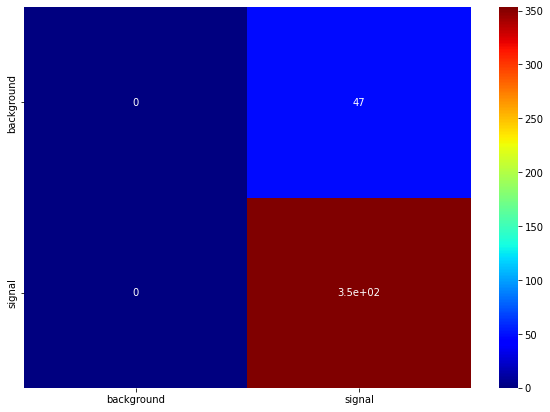

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion_matrix(reals.flatten(), preds.flatten()), index = ['background', 'signal'],
                  columns = ['background', 'signal'])
plt.figure(figsize = (10,7))
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.heatmap(df_cm, annot=True, cmap="jet")
plt.show()

# Confusion matrix whose i-th row and j-th column entry indicates the number of samples with true label being i-th class and predicted label being j-th class.

In [11]:
np.sum(reals.flatten())

361

In [15]:
torch.save(net, './model_save_train_x.pth')

In [17]:
net = torch.load('./model_save_train_x.pth')


In [24]:
confusion_matrix(reals.flatten(), preds.flatten())

array([[ 45,  12],
       [  8, 335]], dtype=int64)